<a href="https://colab.research.google.com/github/ykato27/Self-Supervised-Learning/blob/main/Self_Supervised_Learning_SimCLR_pytorch_lightning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 自己教師付き学習

---

DNNは一般的に，大量の教師ラベル付きデータを用いて学習を行うことで高い認識性能を発揮しています．しかし，教師ラベルは人手によって付与されるため，データ数に比例して人的コストが増えてしまいます．また，問題設定によっては画像に対して1ピクセル毎のラベル付けが必要な場合やデータ自体を集めることが困難な場合もあります．これらのことから期待される問題設定やタスクに対して理想的なデータセット（大量の教師ラベル付きデータ）を用意するのは多くの場合困難です．このような問題を解決する学習方法の１つとして「自己師付き学習」があります．

<img src="https://dl.dropboxusercontent.com/s/cw3nd3iq0ggb01g/sup.png" width = 55%>

自己教師付き学習（Self-supervised Learning）は，教師ラベルのないデータを用いた学習方法です．教師ラベルなしデータに対して，独自の問題を設計することで疑似的な教師ラベルを付与し，ネットワークの学習を行います．

<img src="https://dl.dropboxusercontent.com/s/6qlgcye8hr4blaq/self_sup.png" width = 55%>

自己教師付き学習として様々な学習方法が提案されてますが，ここではContrastive Learningという枠組みについて紹介します．

# Contrastive Learning

Contrastive Learningは，似た入力データは特徴空間においても似た特徴ベクトルとなり，異なるデータは異なる特徴ベクトルとなるように学習する手法です．
具体的には，同一画像に対してノイズや幾何学変換などを行い，ノイズや幾何学変換を行う前の画像が同じ場合は特徴ベクトルを近づけ，異なる場合は離すように学習を行います．
つまり，ネットワークは「複数あるデータの中から変換前が同じ画像の組み合わせを見つける」という問題を解いていることになります．
この一連の処理は，「13_半教師付き学習」で紹介したConsistency Regularizationと似た学習ではありますが，Contrastive Learningでは異なるデータに対しても関係づけを行っています．

<img src="https://dl.dropboxusercontent.com/s/r7yrz62wtt0g7iw/semi_sup_CR.png" width = 55%>

今回は，Contrastive Learningの中でも「A Simple Framework for Contrastive Learning（SimCLR）」という手法について紹介すると共に，簡単な問題設定から実際に学習を行います．

# SimCLR

## 学習方法
ミニバッチの取得以降の学習の流れは以下のようになります．

1. ミニバッチ内の各データに対して，データ増幅を適用し，1つのデータから2つのデータ増幅適用データを作成\
（データ数がN枚から２N枚へ増加）
2. データをネットワーク(+MLP)に入力
3. ネットワークが出力した特徴ベクトル間の類似度を計算

<img src="https://dl.dropboxusercontent.com/s/rte7jfpzb3md7tg/SimCLR_2.png" width = 55%>

このとき，学習を行うネットワークは，特徴抽出器に該当する部分のみを利用し，ネットワークが抽出した特徴ベクトルをMLP（２～３層の多層パーセプトロン）へ入力します．
特徴ベクトルの類似度計算には，MLPが出力した特徴ベクトルを利用します．

## 損失式
２N枚に拡張したミニバッチの中には，ある１枚のデータに対して，1枚の近づけたいデータと(2N-2)枚の離したいデータがあります．
そのため，データ毎に近づけたいデータと離したいデータの組み合わせが異なることになります．

特徴ベクトル間の類似度計算には，コサイン類似度を利用します．
コサイン類似度はベクトル間のなす角度を計算し，値が1に近いほど２つのベクトルの向きが近いことを表します．

損失設計は以下のようになり，この損失式を NT-Xent（Normalized Temperature-scaled CROSS entropy）損失と呼びます．
このとき，$z_i$は基準となるデータの特徴ベクトル，$z_j$は近づけたいデータの特徴ベクトル，$T$は温度パラメータ，$N$はバッチサイズを表します．
この損失計算をミニバッチ内のデータ毎に行い，最終的な損失とします．

<img src="https://dl.dropboxusercontent.com/s/zztz70av6dgmwdj/SimCLR_loss.png" width = 55%>

この損失式を整えると以下のようになります．\
近づけたい特徴ベクトルの類似度が分母，離したい特徴ベクトルの類似度が分子となることがわかります．\
損失値を小さくするために，分母を大きく，分子を小さくするような学習が行われます．

<img src="https://dl.dropboxusercontent.com/s/6v0hob1q5r6szl9/SimCLR_loss2.png" width = 55%>


## データ増幅
Contrastive Learningの項において，ネットワークは「複数あるデータの中から変換前が同じ画像の組み合わせを見つける」という問題を解いていると説明しました．
実際には，どのような問題を解いているのでしょうか？

SimCLRではデータ増幅として主に「クロップ」，「リサイズ」，「明るさ，コントラスト，彩度，色相の変化」を利用しています．\
「クロップ」について着目すると以下のような２つの問題設定が考えられます．

<img src="https://dl.dropboxusercontent.com/s/8785c0qxjpqaqor/data_aug.png.png" width = 70%>

このとき，「リサイズ」はランダムなサイズでクロップした画像に対して，画像サイズが原画像と同じになるように変更します．\
また，同一画像をもとにしたクロップ画像は色情報やヒストグラムが似た画像になりやすいです．
そのため，「明るさ，コントラスト，彩度，色相」をランダムに変化させることで，ネットワークが色情報だけに着目しないようにします．

## 学習の評価
Contrastive Learningによって学習が行われるのは，ネットワークの特徴抽出器とMLPのみのため，クラス分類問題などによる評価を行うことができません．そのため，最終的な評価時は，MLPを取り外し，ネットワークの特徴抽出器と問題設定に合わせたクラス識別器を用いて再学習やファインチューニングを行います．

SimCLRの論文内では以下の３つの実験から学習方法の評価を行っています．

1. 線形評価　　　：クラス識別器のみをデータセットを用いて学習
2. 半教師付き学習：特徴抽出器とクラス識別器をデータセットの1～10\%のラベル付きデータから学習
3. 転移学習　　　：クラス識別器のみの学習と特徴抽出器とクラス識別器の学習の２つから評価

# 畳み込みニューラルネットワークの自己教師付き学習
クラス分類問題のデータセットを用いて，SimCLRに基づいたネットワークの学習を行います．

## モジュールの読み込み
まず初めにGoogle Colaboratory上にインストールされていないライブラリのインストールを行います．\
インストール時のログが長いため，「%%capture」というセルマジックを使い，ログを非表示にします．

In [1]:
%%capture
! pip install git+https://github.com/PytorchLightning/pytorch-lightning-bolts.git@master --upgrade
! pip install pytorch-lightning==1.5.5

In [2]:
from time import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.optim import Adam, Optimizer

from pl_bolts.optimizers.lr_scheduler import LinearWarmupCosineAnnealingLR
from pl_bolts.optimizers.lars import LARS

## データセットの準備

### データ増幅の定義
SimCLRによる学習を行うには，教師なしデータ１枚につき，データ増幅を施した２枚の画像を取得する必要があります．\
「13_半教師付き学習」では，自作のDatasetクラスによって実現しましたが，今回は自作のデータ増幅クラスによって実現します．

In [3]:
# 自作データ増幅クラス
class TransformsSimCLR:
    def __init__(self):
        c_w = 0.5   # color_jitterの強さの調整
        color_jitter = transforms.ColorJitter(0.8*c_w, 0.8*c_w, 0.8*c_w, 0.2*c_w)  # ランダムに明るさ,コントラスト,彩度,色相を変化
        self.train_transform = transforms.Compose([
            transforms.RandomResizedCrop(32),               # ランダムにクロップして32×32のサイズで出力
            transforms.RandomHorizontalFlip(),              # ランダムに左右反転
            transforms.RandomApply([color_jitter], p=0.8),  # 80%の確率でcolor_jitterを適用
            transforms.RandomGrayscale(p=0.2),              # 20%の確率で画像をグレー画像化
            transforms.ToTensor(),                          # 画像をtensor化
        ])
        
    def __call__(self, x):
        return self.train_transform(x), self.train_transform(x)  # 画像に対して２回データ増幅を適用

### データセットの定義
自己教師付き学習手法の評価には，一般的に教師付き学習に用いるベンチマークデータセットが利用されます．\
データセットとして，一般物体認識用データセットであるCIFAR-10を用います．\
CIFAR-10は，10クラス（飛行機，自動車，鳥，猫，鹿，犬，カエル，馬，船，トラック）の画像から構成されるデータセットです．

SimCLRではデータ増幅を施したミニバッチ内の全てのデータ間で距離を計算し，近づける・離す学習を行います．そのため，ミニバッチサイズが大きいほど多くのデータを考慮した学習となります．今回はミニバッチサイズを512とします．\
（SimCLRの論文内では256~2048で実験が行われています）

また，Contrastive Learningでは，クラス識別器を学習しないため，評価用データによる学習途中の評価ができません．そのため，ここでは評価用データセットの定義は行いません．

In [4]:
BATCH_SIZE = 512  # ミニバッチサイズ

train_data = torchvision.datasets.CIFAR10(root="./dataset/CIFAR-10", 
                                          train=True,
                                          transform=TransformsSimCLR(), # 自作のデータ増幅クラス
                                          download=True)

train_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size=BATCH_SIZE,
                                           shuffle=True,
                                           drop_last=True,
                                           num_workers=10)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./dataset/CIFAR-10/cifar-10-python.tar.gz to ./dataset/CIFAR-10


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


### データの可視化
ここでは先程定義した自作データ増幅クラスによって，１つの教師なしデータに対してどのような処理が行われたのか（視覚的にどう違うのか）を確認します．

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


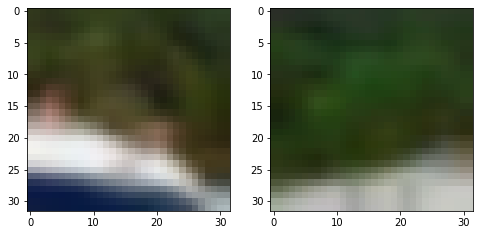

In [5]:
import matplotlib.pyplot as plt

tmp = train_loader.__iter__()
(image_i, image_y), label = tmp.next()

for i in range(1):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8,4))

    ax1.imshow(image_i[i].permute(1,2,0))
    ax2.imshow(image_y[i].permute(1,2,0))

    fig.show()

## ネットワークの準備

### ネットワークの定義
畳み込みニューラルネットワークの定義をします．\
ここでは，10.knowledge_distillation，11.deep_mutual_learning，13.半教師付き学習で使用したネットワークと同様のものを利用します．

In [6]:
class CNN(nn.Module):
    def __init__(self, widen_factor=1):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16*widen_factor, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16*widen_factor, 32*widen_factor, kernel_size=3, stride=1, padding=1)
        self.l1 = nn.Linear(8*8*32*widen_factor, 1024*widen_factor)
        self.l2 = nn.Linear(1024*widen_factor, 1024*widen_factor)
        self.l3 = nn.Linear(1024*widen_factor, 10)
        self.act = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
    
    def forward(self, x):
        h = self.pool(self.act(self.conv1(x)))
        h = self.pool(self.act(self.conv2(h)))
        h = h.view(h.size()[0], -1)
        h = self.act(self.l1(h))
        h = self.act(self.l2(h))
        h = self.l3(h)
        return h

### 多層パーセプトロン(MLP)の定義
SimCLRでは，ネットワークの出力した特徴量をMLPに入力し，MLPの出力した特徴量を距離計算に利用します．\
今回は，２層の畳み込み層と３層の全結合層からなるネットワークの中で，２層目の全結合層の出力をMLPへの入力とします．\
この時，学習後の評価のために，ネットワークによる特徴量とMLPによる特徴量の２つを出力するように設計します．

また，損失計算を簡単にするために，データ増幅を適用した2N枚のデータをそのままネットワークへ入力するのではなく，N枚ずつのデータを２つ入力する形にします．

そのため，ネットワークは特徴抽出器の出力２つとMLPの出力２つの計４つの特徴ベクトルを出力します．

In [7]:
# 入力をそのまま出力とする層の定義
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x

# MLPを含めたネットワークの定義
class SimCLR(nn.Module):
    def __init__(self, encoder, n_features, projection_dim=64):
        super(SimCLR, self).__init__()
        self.encoder    = encoder     # ネットワーク
        self.n_features = n_features  # ネットワークの3層目の全結合層の入力サイズ
        self.encoder.l3 = Identity()  # ネットワークの3層目の全結合層を変更（入力値をそのまま返すように変更）
        self.projection_dim = projection_dim  # MLPの出力サイズ

        # MLPの定義
        self.projector = nn.Sequential( nn.Linear(self.n_features, self.n_features, bias=False),
                                        nn.ReLU(),
                                        nn.Linear(self.n_features, self.projection_dim, bias=False) )

    def forward(self, x_i, x_j):
        # ネットワークへ入力
        h_i = self.encoder(x_i)
        h_j = self.encoder(x_j)
        # ネットワークの出力した特徴量をMLPへ入力
        z_i = self.projector(h_i)
        z_j = self.projector(h_j)
        # ネットワークによる特徴量とMLPによる特徴量を出力するように設計
        return h_i, h_j, z_i, z_j

In [8]:
encoder = CNN(widen_factor=1)        # ネットワークの定義
n_features = encoder.l3.in_features  # ネットワークの３層目の全結合層の入力サイズの取得
net = SimCLR(encoder, n_features)    # MLPを含めたネットワークの定義

## 損失関数の定義
ここでは，NT-Xent（Normalized Temperature-scaled CROSS entropy）損失を実装します．
損失式は以下のようになります．

<img src="https://dl.dropboxusercontent.com/s/zztz70av6dgmwdj/SimCLR_loss.png" width = 40%>

このとき，この損失式は1つのデータ$z_i$に対する損失値を計算するものでした．\
基準とするデータ$z_i$によって分母の構成が変わるため，１つのデータ毎にこの損失計算をする必要があります．

プログラム上では，この損失式を３段階の工程（forward内）から実現しています．\
ここでは例として，ミニバッチサイズを３とした場合の３段階の処理について解説します．
データ増幅適用前のデータをA，B，C，データ増幅適用後のデータをA1，A2，B1，B2，C1，C2とします．\
自作データ増幅クラス TransformsSimCLRは，データ増幅適用後のデータを(A1，B1，C1)と(A2，B2，C2)の２つに分けて出力するように設定しています．
そのため，ネットワークの出力する特徴ベクトルも(A1，B1，C1)と(A2，B2，C2)の２つに分かれています．

\
１段階目では，２つに分かれている特徴ベクトルを結合します．
結合は，「torch.cat」で行い，第一引数に結合したいテンソル「(z_i, z_j)」を指定します．
このとき，第一引数の１つ目に指定したテンソル「z_i」の一番後ろに２つ目に指定したテンソル「z_j」が結合される形になります．
そのため，特徴ベクトルの順番は，(A1，B1，C1，A2，B2，C2)のようになります．\
次に「self.similarity_f(z.unsqueeze(1), z.unsqueeze(0)) / self.temperature」で全ての特徴ベクトル間のコサイン類似度を計算します．
これによって式内の「${\rm sim}()/T$」が計算されます．
ここで作成されるテンソルは以下のような形になります．

<img src="https://dl.dropboxusercontent.com/s/pzsr045caryivm1/loss_1.png" width = 55%>

\
２段階目では，損失計算に必要な類似度のみを取り出します．\
近づけたい類似度は，(A1，A2)，(B1，B2)，(C1，C2)，(A2，A1)，(B2，B1)，(C2，C1)です．\
近づけたい類似度が先程作成したテンソルのどこにあるのかを確認すると，左上から右下にかけて斜めに配置されていることがわかります．
「torch.diag」を利用することで，第一引数で指定したテンソル内の対角線を基準として，第二引数によって以下のように左上から右下にかけて斜めにテンソル内の要素を取り出すことができます．テンソルの要素指定は，0から始まるため，ちょうどバッチサイズと同じ値を指定することで，取り出したい要素を指定できることがわかります．

<img src="https://dl.dropboxusercontent.com/s/ztw8u2ya3b2y1lz/loss_2.png.png" width = 58%>

その後，取り出した２つのテンソルを「torch.cat」によって一つにします．\
これによって作成される類似度の順番は ( (A1,A2)，(B1,B2)，(C1,C2)，(A2,A1)，(B2,B1)，(C2,C1) ) になります．

次に「sim[self.mask].reshape(N, -1)」によって，全ての類似度を収納しているテンソルから先程取り出した近づけたい類似度や同じ特徴ベクトル間の類似度を削除し，形を整えます．
これにより，このテンソルは離したい類似度のみを収納したテンソルになります．

最後に「torch.cat((positive_samples, negative_samples), dim=1)」によって近づけたい類似度と離したい類似度を１つのテンソルにします．
ここで作成されるテンソルは以下のような形になります．

<img src="https://dl.dropboxusercontent.com/s/g4izlda80i14696/loss_3.png.png.png" width = 55%>

テンソルの形が(6,5)になりました．\
(0,0)，(1,0)，(2,0)といった0番目の要素が近づけたい類似度（オレンジ背景），0番目以外の要素が離したい類似度（白背景）になっていることがわかります．
これによって0番目の要素を取り出すことでNT-Xent損失の分子にあたる「${\rm sim}(z_i,z_j)/T$」，0～4番目の要素を取り出すことで分母にあたる「${\rm sim}(z_i,z_k)/T$」の計算結果を取り出すことができるようになりました．

\
３段階目では，損失計算を行います．\
損失計算には「nn.CrossEntropyLoss()」を利用します．
このクラスはクロスエントロピー損失を計算します．\
クロスエントロピー損失の式は以下のようになります．

\begin{equation}
E=-\sum_i^{nclass} t_i \log y_i
\end{equation}

そのため，NT-Xent損失の式と見比べてどの計算に利用するのか疑問に思うかもしれません．\
「nn.CrossEntropyLoss()」クラスは，上記のようなクロスエントロピー損失のみを計算するクラスではなく，ソフトマックス関数の計算を内包したクラスです．
そのため，数式で表すと以下のようになります．

\begin{equation}
E=-\log(\frac{\exp(y_{label})}{\sum_i^{nclass} \exp(y_i)})
\end{equation}

このとき，$y_{label}$は正解クラス（正確には第二引数により指定されたクラス）を表します．\
２段階目で作成したテンソルは，０番目の要素が近づけたい類似度（NT-Xent損失の分子）であるため，第二引数として０を指定し，「nn.CrossEntropyLoss()」クラスにテンソルを渡すことでNT-Xent損失が計算されます．\
「torch.zeros(N).to(positive_samples.cuda()).long()」で０を指定するテンソルを作成し，「self.criterion(logits, labels)」で損失を計算しています．
このとき，「nn.CrossEntropyLoss(reduction="sum")」とinitで宣言しているため，出力される損失は各特徴ベクトルに対して計算されたNT-Xent損失の合計となっています．
今回は，各特徴ベクトルに対して計算されたNT-Xent損失の平均を最終的な損失とします．




In [9]:
class NT_Xent(nn.Module):
    def __init__(self, batch_size=128, temperature=1):
        super(NT_Xent, self).__init__()
        self.batch_size  = batch_size   # ミニバッチサイズ
        self.temperature = temperature  # 温度パラメータ

        self.mask = self.mask_correlated_samples(batch_size)      # マスクテンソルの作成
        self.criterion    = nn.CrossEntropyLoss(reduction="sum")  # クロスエントロピー(softmaxを内包)
        self.similarity_f = nn.CosineSimilarity(dim=2)            # コサイン類似度

    # 同一画像の類似度と近づけたい類似度を削除するためのマスクの作成
    def mask_correlated_samples(self, batch_size):
        N    = 2 * batch_size
        mask = torch.ones((N, N), dtype=bool)
        mask = mask.fill_diagonal_(0)  # 同一画像の類似度が入っている位置のテンソルを0に
        for i in range(batch_size):
            mask[i, batch_size+i] = 0  # 近づけたい類似度が入っている位置のテンソルを0に
            mask[batch_size+i, i] = 0  # 近づけたい類似度が入っている位置のテンソルを0に
        return mask

    def forward(self, z_i, z_j):
        # ------ 1 --------------------------------------------------------------------------
        N = 2 * self.batch_size
        z = torch.cat((z_i, z_j), dim=0)  # ネットワークの２つの出力を1つのテンソルに
        sim = self.similarity_f(z.unsqueeze(1), z.unsqueeze(0)) / self.temperature  # 全てのデータ間の類似度を計算

        # ------ 2 --------------------------------------------------------------------------
        sim_i_j = torch.diag(sim,  self.batch_size)  # 近づけたい類似度(i->j))を抽出
        sim_j_i = torch.diag(sim, -self.batch_size)  # 近づけたい類似度(j->i))を抽出

        positive_samples = torch.cat((sim_i_j, sim_j_i), dim=0).reshape(N, 1)  # 近づけたい特徴間の類似度を1つのテンソルに
        negative_samples = sim[self.mask].reshape(N, -1)                       # 離したい特徴間の類似度のみのテンソルの作成

        logits = torch.cat((positive_samples, negative_samples), dim=1)  # 近づけたい特徴間の類似度と離したい特徴間の類似度を1つのテンソルに

        # ------ 3 --------------------------------------------------------------------------
        labels = torch.zeros(N).to(positive_samples.cuda()).long()  # 近づけたい類似度の位置を表すテンソルを作成

        loss = self.criterion(logits, labels)  # 損失計算 = -log( exp(logits[labels])/sum(exp(logits)) )
        loss /= N                              # データ数で除算（平均）
        return loss

## 学習条件の設定
ミニバッチサイズが大きい場合，1 epochあたりのiteration数が少なくなるため，同一の学習回数（epoch数）におけるネットワークの総更新回数が少なくなります．
そのため，一般的には，学習率や学習回数を大きく設定します．
しかし，学習率が大きい場合，学習が不安定になることがあります．
そこで，学習率を勾配に合わせて調整するLARS（Layerwise Adaptive Rate Scaling），学習率を学習初期は小さな値として徐々に一定の値まで上げるWarmupを利用します．

今回は，学習回数を100 epoch，学習率を0.01とします．Google colaboratory上では1 epochあたり約1分弱（100 epochで約2時間）の時間がかかります．
そのため，学習回数は適宜調整してください．

In [10]:
# 学習条件の設定
NUM_EPOCH = 100
#LR = 0.3*(BATCH_SIZE/256)  # SimCLRで使われているミニバッチサイズに合わせた学習率の調整式
LR = 0.01

criterion = NT_Xent(BATCH_SIZE, 0.5)
model = torch.nn.Linear(10, 3) # 仮のネットワークを作成
optimizer = Adam(model.parameters(), lr=0.02)
scheduler = LinearWarmupCosineAnnealingLR(optimizer, warmup_epochs=10, max_epochs=NUM_EPOCH, warmup_start_lr=0, eta_min=0)

### 学習率の推移の可視化
Warmupを適用することでどのうように初期学習率がふるまうのか確認をします．

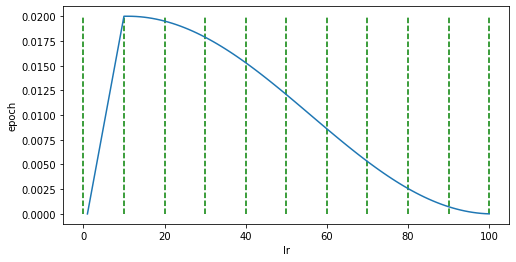

In [11]:
import numpy as np
# 学習率の推移の可視化
def print_lr(LR, NUM_EPOCH):
    model = torch.nn.Linear(10, 3) # 仮のネットワークを作成
 
    # 可視化したい条件
    lr_list = list()
    optimizer = Adam(model.parameters(), lr=0.02)
    scheduler = LinearWarmupCosineAnnealingLR(optimizer, warmup_epochs=10, max_epochs=NUM_EPOCH, warmup_start_lr=0, eta_min=0)

    # 学習率の取得
    for step in range(NUM_EPOCH):
        lr_list.append(scheduler.get_last_lr()[0])
        optimizer.step()
        scheduler.step()

    # 学習率の推移を描画
    plt.figure(figsize=(8, 4))
    plt.plot([i+1 for i in range(len(lr_list))], lr_list)
    # 10 epoch刻みで縦線を描画
    plt.vlines([10*i for i in range(int((NUM_EPOCH/10)+1))], 0, np.array(lr_list).max(), "green", linestyles='dashed')
    # x軸とy軸のラベルを描画
    plt.xlabel('lr')
    plt.ylabel('epoch')
    plt.show()

# 学習率の推移の確認
print_lr(LR, NUM_EPOCH)

## ネットワークの学習

In [12]:
# ネットワークをGPUへ
net = net.cuda()

# ネットワークを学習モードへ変更
net.train()

start = time()
for epoch in range(1, NUM_EPOCH+1):
    sum_loss = 0.0
    
    for (image_i, image_y), _ in train_loader:
        image_i = image_i.cuda()
        image_y = image_y.cuda()
        
        _, _, z_i, z_j = net(image_i, image_y)
        
        # 損失の計算
        loss = criterion(z_i, z_j)
        
        # パラメータの更新
        net.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        # ログ用に損失と精度の取得
        sum_loss += loss.item()
       
    # ログの表示
    if (epoch%5 == 0):
        print(f"epoch: {epoch}, mean loss: {round(sum_loss/len(train_loader), 3)}, elapsed_time :{round(time()-start, 2)}")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch: 5, mean loss: 6.901, elapsed_time :403.3
epoch: 10, mean loss: 6.901, elapsed_time :812.27
epoch: 15, mean loss: 6.901, elapsed_time :1216.76
epoch: 20, mean loss: 6.901, elapsed_time :1623.03
epoch: 25, mean loss: 6.901, elapsed_time :2032.69
epoch: 30, mean loss: 6.901, elapsed_time :2446.5
epoch: 35, mean loss: 6.901, elapsed_time :2857.68
epoch: 40, mean loss: 6.901, elapsed_time :3270.14
epoch: 45, mean loss: 6.901, elapsed_time :3683.5
epoch: 50, mean loss: 6.901, elapsed_time :4097.54
epoch: 55, mean loss: 6.902, elapsed_time :4515.31
epoch: 60, mean loss: 6.901, elapsed_time :4930.85
epoch: 65, mean loss: 6.901, elapsed_time :5345.16
epoch: 70, mean loss: 6.901, elapsed_time :5759.48
epoch: 75, mean loss: 6.901, elapsed_time :6175.39
epoch: 80, mean loss: 6.902, elapsed_time :6589.77
epoch: 85, mean loss: 6.901, elapsed_time :7005.38
epoch: 90, mean loss: 6.901, elapsed_time :7423.43
epoch: 95, mean loss: 6.901, elapsed_time :7843.11
epoch: 100, mean loss: 6.901, elapsed

## 線形評価によるネットワークの評価
線形評価からSimCLRによって学習した特徴抽出器の評価を行います．
ここでは，「13_半教師付き学習」の結果と比較できるように，計100枚の学習用データからクラス識別器の学習を行い，評価用データを用いて精度を算出します．

In [13]:
import random
from sklearn.model_selection import StratifiedShuffleSplit
from collections import defaultdict
from torch.utils.data import Sampler
from torch.utils.data import SubsetRandomSampler, Subset, Dataset

## データセットの準備
今回は，学習用データの数が小さいため，ミニバッチサイズを小さく設定します．
そのため，ミニバッチを各クラスからバランスよく取得することを考えます．
データセットの中から取得するデータを決定するアルゴリズムはSamplerクラスにより制御します．\
今回は自作のSamplerクラスを利用します．

In [14]:
# 自作 Sampler
class StratifiedSampler(Sampler):
    def __init__(self, labels):
        self.idx_by_lb = defaultdict(list)
        for idx, lb in enumerate(labels):
            self.idx_by_lb[lb].append(idx)

        self.size = len(labels)

    def __len__(self):
        return self.size

    def __iter__(self):
        songs_list = []
        artists_list = []
        for lb, v in self.idx_by_lb.items():
            for idx in v:
                songs_list.append(idx)
                artists_list.append(lb)

        shuffled = spotifyShuffle(songs_list, artists_list)
        return iter(shuffled)


def fisherYatesShuffle(arr):
    for i in range(len(arr)-1, 0, -1):
        j = random.randint(0, i)
        arr[i], arr[j] = arr[j], arr[i]
    return arr


def spotifyShuffle(songs_list, artists_list):
    artist2songs = defaultdict(list)
    for artist, song in zip(artists_list, songs_list):
        artist2songs[artist].append(song)
    songList = []
    songsLocs = []
    for artist, songs in artist2songs.items():
        songs = fisherYatesShuffle(songs)
        songList += songs
        songsLocs += get_locs(len(songs))
    return [songList[idx] for idx in argsort(songsLocs)]


def get_locs(n):
    percent = 1. / n
    locs = [percent * random.random()]
    last = locs[0]
    for i in range(n - 1):
        value = last + percent * random.uniform(0.8, 1.2)
        locs.append(value)
        last = value
    return locs


def argsort(seq):
    return [i for i, j in sorted(enumerate(seq), key=lambda x:x[1])]

### データ増幅の定義
今回は，先程学習した特徴抽出器の構造を変更等せずにそのまま利用します．\
そのため，学習へは利用しませんが，ネットワークへ２つの画像を入力する必要があります．

In [15]:
class TransformsSimCLR_test:
    def __init__(self):
        self.test_transform = torchvision.transforms.Compose([
            transforms.ToTensor(),
        ])

    def __call__(self, x):
        return self.test_transform(x), self.test_transform(x)

### データセットの定義

In [16]:
total_trainset = torchvision.datasets.CIFAR10(root="./dataset/CIFAR-10", train=True,  download=False, transform=TransformsSimCLR_test())

sss = StratifiedShuffleSplit(n_splits=1, test_size=49900, random_state=0)
sss = sss.split(list(range(len(total_trainset))), total_trainset.targets)
label_idx, unlabel_idx = next(sss)

trainset = Subset(total_trainset, label_idx)
train_labels = [total_trainset.targets[idx] for idx in label_idx]
trainset.train_labels = train_labels

print("学習用データ数：", len(trainset))

学習用データ数： 100


In [17]:
testset = torchvision.datasets.CIFAR10(root="./dataset/CIFAR-10", train=False, download=False, transform=TransformsSimCLR_test())

# 教師付きデータセット用 Dataloader
train_loader = torch.utils.data.DataLoader(trainset, 
                                           batch_size=10, 
                                           shuffle=False,   # Samplerを利用するためFalse
                                           num_workers=10,
                                           pin_memory=True,
                                           sampler=StratifiedSampler(trainset.train_labels),  # 自作のSampler
                                           drop_last=True)

# 評価データ用 Dataloader
test_loader  = torch.utils.data.DataLoader(testset, 
                                           batch_size=1000,
                                           shuffle=False, 
                                           num_workers=10, 
                                           pin_memory=True, 
                                           drop_last=False)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## クラス識別器の用意

In [18]:
class LogisticRegression(nn.Module):
    def __init__(self, n_features, n_classes):
        super(LogisticRegression, self).__init__()

        self.model = nn.Linear(n_features, n_classes)

    def forward(self, x):
        return self.model(x)

In [19]:
net_fc = LogisticRegression(net.encoder.l2.out_features, 10)

## クラス識別器の学習
SimCLRの学習を行う際にネットワークの定義において，MLPの出力に加え，ネットワークの特徴抽出器の出力も取得できるように設計しました．
そのため，ネットワークの特徴抽出器が出力した特徴ベクトルを先程定義したクラス識別器へ入力することで最終的なlogtsを獲得します．

In [20]:
optimizer = torch.optim.Adam(net_fc.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

In [21]:
# エポック数の設定
NUM_EPOCH = 10

# ネットワークとクラス識別器をGPUへ
net    = net.cuda()
net_fc = net_fc.cuda()

# ネットワークを学習モードへ変更
net.eval()
net_fc.train()

start = time()
for epoch in range(1, NUM_EPOCH+1):
    sum_loss = 0.0
    count = 0
    
    for (image_i, image_y), label in train_loader:
        image_i = image_i.cuda()
        image_y = image_y.cuda()
        label   = label.cuda()
        
        with torch.no_grad():
            h, _, _, _ = net(image_i, image_y)  #  特徴抽出器へ入力
            
        h = h.detach()
        y = net_fc(h)  # クラス識別器へ入力

        # 損失の計算
        loss = criterion(y, label)
        
        # パラメータの更新
        net_fc.zero_grad()
        loss.backward()
        optimizer.step()
        
        # ログ
        sum_loss += loss.item()
        
        pred   = torch.argmax(y, dim=1)
        count += torch.sum(pred == label)
        
        # ログの表示
    print(f"epoch: {epoch}, mean loss: {round(sum_loss/len(train_loader), 3)}, mean accuracy: {round(count.item()/len(train_loader.dataset), 2)}, elapsed_time :{round(time()-start, 2)}")

    
# ネットワークを評価モードへ変更
net_fc.eval()

# 評価の実行
count = 0
with torch.no_grad():
    for (image_i, image_y), label in test_loader:
        image_i = image_i.cuda()
        image_y = image_y.cuda()
        label   = label.cuda()
        
        h, _, _, _ = net(image_i, image_y)
        y = net_fc(h)
        
        pred = torch.argmax(y, dim=1)
        count += torch.sum(pred == label)

print(f"test accuracy: {count.item()/len(test_loader.dataset)}")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch: 1, mean loss: 2.304, mean accuracy: 0.1, elapsed_time :0.73
epoch: 2, mean loss: 2.255, mean accuracy: 0.24, elapsed_time :1.4
epoch: 3, mean loss: 2.215, mean accuracy: 0.38, elapsed_time :2.12
epoch: 4, mean loss: 2.175, mean accuracy: 0.5, elapsed_time :2.79
epoch: 5, mean loss: 2.143, mean accuracy: 0.51, elapsed_time :3.5
epoch: 6, mean loss: 2.109, mean accuracy: 0.5, elapsed_time :4.18
epoch: 7, mean loss: 2.076, mean accuracy: 0.63, elapsed_time :4.89
epoch: 8, mean loss: 2.051, mean accuracy: 0.63, elapsed_time :5.55
epoch: 9, mean loss: 2.022, mean accuracy: 0.57, elapsed_time :6.23
epoch: 10, mean loss: 1.995, mean accuracy: 0.59, elapsed_time :6.89
test accuracy: 0.2212
